# 6.1: 1次元入力2クラス分類

## 6.1.1 問題設定

昆虫の重量と性別の人口データを作成する。

In [33]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# データ生成
np.random.seed(seed=0)  # 乱数を固定
X_min, X_max = 0, 2.5   # Xの範囲
N = 30                  # データ数
col = ['cornflowerblue', 'gray']  # グラフの色
X = np.zeros(N)         # 入力データ
T = np.zeros(N, dtype=np.uint8)  # 目標データ
prm_s = [0.4, 0.8]      # 分布の開始位置
prm_w = [0.8, 1.6]      # 分布の幅
prm_pi = 0.5            # クラス1の比率
for n in range(N):
    r = np.random.rand()
    T[n] = 0 * (r < 0.5) + (r >= prm_pi)
    X[n] = prm_s[T[n]] + np.random.rand() * prm_w[T[n]]

# データ表示
print('X = ', np.round(X, 2))
print('T = ', T)


X =  [1.94 1.67 0.92 1.11 1.41 1.65 2.28 0.47 1.07 2.19 2.08 1.02 0.91 1.16
 1.46 1.02 0.85 0.89 1.79 1.89 0.75 0.9  1.87 0.5  0.69 1.5  0.96 0.53
 1.21 0.6 ]
T =  [1 1 0 0 1 1 1 0 0 1 1 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1 1 0 1 0]


データの表示

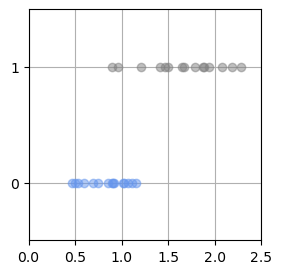

In [34]:
def show_data1d(x, t):
    for k in range(2):
        plt.plot(
            x[t == k], t[t == k], col[k],
            alpha = 0.5, linestyle='none', marker='o'
        )
    plt.xticks(np.arange(0, 3, 0.5))
    plt.yticks([0, 1])
    plt.xlim(X_min, X_max)
    plt.ylim(-0.5, 1.5)

# メイン
fig = plt.figure(figsize=(3, 3))
show_data1d(X, T)
plt.grid()
plt.show()

## 6.1.3 最尤推定

### 尤度とは
その確率であることの適切さを表したもの

例えば、くじを引いたとして、初めの3回は0(ハズレ)、次の1回は1(当たり)という問題を考える。 \
この時、1を引く確率をwとし、w=0.1とすると、 \\
クラスデータT=0, 0, 0, 1がモデルから生成された確率を尤度という。\
実際に尤度を計算してみると、　\
$ 0.9 × 0.9 × 0.9 × 0.1 = 0.072 $
となる\
しかし、w=0.2の時の尤度を計算してみると、
$ 0.8 × 0.8 × 0.8 × 0.2 = 0.102 $
となり、こちらの方が尤度が高く、尤もらしいと言える

### 最尤推定とは
尤度が最も高くなる確率wを求めること。

上の問題で最尤推定をすると、\
$ P(T=0,0,0,1|x) = (1-w)^3 w $ \
このグラフは、上に凸の形になるため最大値を取る値wが尤もらしい値となり、推定値として扱われる。

その後の流れとしては、
1. 対数をとる\
  a. 掛け算を足し算にするため
2. 微分した値　＝　0で計算する

## 6.1.4 ロジスティック回帰モデル

ロジスティック回帰モデルは直線の式をシグモイド関数に通したもの。

直線の式
$$ y = w_0x + w_1 $$
ロジスティック回帰モデル
$$ σ(w_0x + w_1) = \frac{1}{1 + exp{-(w_0x + w_1)}} $$

### このモデルのメリット
昆虫がxという重みであった時に、オスである確率、というような条件付き確率を近似しようとするところ。\
曖昧さも含めて予測できるところ。

実際に定義してみる

In [35]:
# ロジスティック回帰モデル
def logistic(x, w):
    y = 1 / (1 + np.exp(-(w[0] * x + w[1])))
    return y

ロジスティック回帰モデルを表示する関数

In [36]:
def show_logistic(w):
    x = np.linspace(X_min, X_max, 100)
    y = logistic(x, w)
    plt.plot(x, y, 'gray', linewidth=4)
    # 決定境界
    i = np.min(np.where(y > 0.5))
    boundary = (x[i - 1] + x[i]) / 2
    plt.plot([boundary, boundary], [-0.5, 1.5], 'k--')
    plt.grid(True)
    return boundary

テスト

decision boundary = 1.25


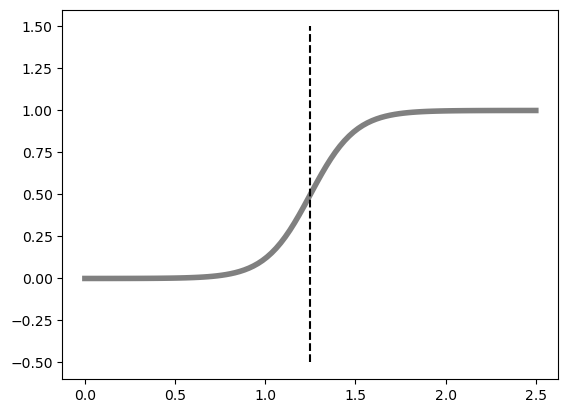

In [37]:
w = np.array([8, -10])
b = show_logistic(w)
print(f'decision boundary = {np.round(b, 2)}')

plt.grid()
plt.show()

## 6.1.5 交差エントロピー誤差(CEE)
最尤推定の式(尤度を求める式)に対数をとり、-1をかけたもののこと

### CEE式の導出
1. ロジスティック回帰モデルを使って、t=1となる確率を表す。
$$ y = σ(w_0x + w_1) = P(t = 1|x) \\
 t:性別, y:tが1となる確率, x:体重 $$

2. このパラメータ$ w_0 $ と$ w_1 $ を最尤推定する。\
まず、t=1となる確率はyがそのまま答えとなるが、\
t = 0となる確率は1-yが答えとなり、不便である。
そこで
指数を使ってスイッチする式を作成
$$ P(t|x) = y^t(1-y)^{1-t} $$

3. それを全て掛け合わせたものが尤度
$$ P(T|X) = \prod_{n=0}^{N-1} y_n^{t_n} (1-y_n)^{1-t_n} $$

4. そして対数をとる
$$ logP(T|X) = \sum_{n=0}^{N-1} \{t_n log y_n (1-t_n)log(1-y_n) \} $$

#### これが交差エントロピー誤差
5. 回帰問題の時には平均二乗誤差が最小になるようにパラメータを求めていたように、最小を求める問題にするために、この式に-1をかける。
  そして、このままだとデータ数が大きくなればなるほど誤差が大きくなるため、Nで割る。\
  これを**平均交差エントロピー誤差**という
$$ E(W) = - \frac{1}{N}logP(T|X) = - \frac{1}{N} \sum_{n=0}^{N-1} \{t_n log y_n + (1 - t_n) log(1-y_n)\}

平均交差エントロピー誤差を計算する関数を作成

In [38]:
def cee_logistic(w, x, t):
    y = logistic(x, w)
    # 上式の計算
    cee = 0
    for n in range(len(y)):
        cee = cee - (t[n] * np.log(y[n]) + (1 - t[n]) * np.log(1 - y[n]))
    cee = cee / N
    return cee

In [39]:
# テスト
w = np.array([1, 1])
cee = cee_logistic(w, X, T)
print(f'CEE = {cee:.2f}')

CEE = 1.03


グラフを見てみる

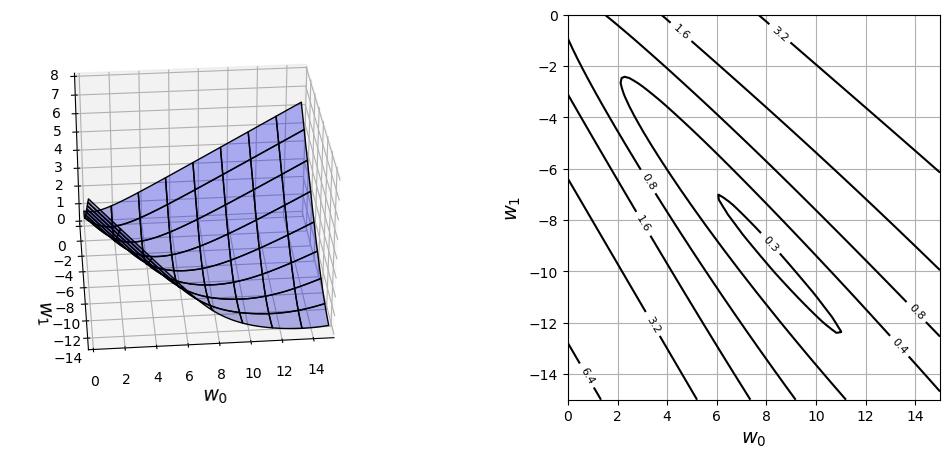

In [40]:
# 平均交差エントロピー誤差の計算
w0_n, w1_n = 80, 80  # 等高線の解像度
w0_min, w0_max = 0, 15
w1_min, w1_max = -15, 0
w0 = np.linspace(w0_min, w0_max, w0_n)
w1 = np.linspace(w1_min, w1_max, w1_n)
C = np.zeros((w1_n, w0_n))
for i0 in range(w0_n):
    for i1 in range(w1_n):
        C[i1, i0] = cee_logistic([w0[i0], w1[i1]], X, T)        # ceeの計算
ww0, ww1 = np.meshgrid(w0, w1)  # メッシュ生成

# グラフ表示
plt.figure(figsize=(12, 5))
plt.subplots_adjust(wspace=0.5)
# サーフェス表示
ax = plt.subplot(1, 2, 1, projection='3d')
ax.plot_surface(ww0, ww1, C, color='blue', edgecolor='black',
                rstride=10, cstride=10, alpha=0.3)
ax.set_xlabel('$ w_0 $', fontsize=14)
ax.set_ylabel('$ w_1 $', fontsize=14)
ax.set_xlim(0, 15)
ax.set_ylim(-15, 0)
ax.set_zlim(0, 8)
ax.view_init(30, -95)
# 等高線表示
plt.subplot(1, 2, 2)
cont = plt.contour(ww0, ww1, C, colors='black', levels=[0.26, 0.4, 0.8, 1.6, 3.2, 6.4])
cont.clabel(fmt='%.1f', fontsize=8)
plt.xlabel('$ w_0 $', fontsize=14)
plt.ylabel('$ w_1 $', fontsize=14)
plt.grid(True)
plt.show()

担当　5.7-5.8

5.6-6.1.5まで

## 6.1.6 学習則の導出

### 学習則
学習アルゴリズムが最適なパラメータを探すためのルールのこと \
例えば勾配降下法などがある

$ y_n $ が非線形のシグモイド関数を含んでいるため、勾配降下法を使って、数値的に求めていく。

平均交差エントロピーの誤差の微分

In [41]:
def dcee_logistic(w, x, t):
    y = logistic(x, w)
    # 上式の計算
    dcee = np.zeros(2)
    for n in range(len(y)):
        dcee[0] = dcee[0] + (y[n] - t[n]) * x[n]
        dcee[1] = dcee[1] + (y[n] - t[n])
    dcee = dcee / N
    return dcee

テスト

In [42]:
w = np.array([1, 1])
dcee = dcee_logistic(w, X, T)
print(f'dCEE = {np.round(dcee, 6)}')

dCEE = [0.308579 0.394855]


## 6.1.7 勾配法による解

scipyのminimize関数を使って勾配法で極小解を求める

- 偏微分を使う
- 共役勾配法
  - 学習率を指定する必要なし
- 指定する引数
  - 誤差関数（交差エントロピー関数）
  - wの初期値
  - 誤差関数の微分

In [43]:
from scipy.optimize import minimize

# ロジスティック回帰モデルのパラメータ最適化
def fit_logistic(w_init, x, t):
    # minimize(誤差関数, 初期値, args=誤差関数の引数, jac=誤差関数の勾配, method=最適化手法)
    res = minimize(cee_logistic, w_init, args=(x, t),
                    jac=dcee_logistic, method="CG")
    return res.x

メイン処理 \
上の関数を使ってみる

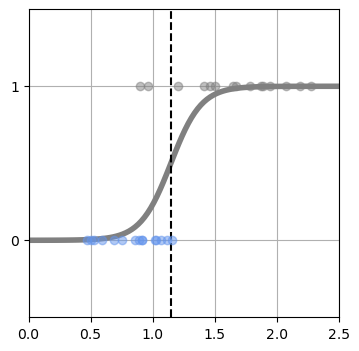

w0 = 8.18, w1 = -9.38
CEE = 0.25
decision boundary = 1.15


In [44]:
w_init = np.array([1.0, -1.0])  # 初期パラメータ
w = fit_logistic(w_init, X, T)  # 最適パラメータの計算
cee = cee_logistic(w, X, T)     # 最適パラメータでのCEE

# グラフ描画
plt.figure(figsize=(4, 4))
boudary = show_logistic(w)
show_data1d(X, T)
plt.grid(True)
plt.show()

# 結果表示
print(f'w0 = {np.round(w[0], 2)}, w1 = {np.round(w[1], 2)}')
print(f'CEE = {cee:.2f}')
print(f'decision boundary = {np.round(boudary, 2)}')

# 2次元入力2クラス分類

## 6.2.1 問題設定

In [45]:
%reset

今までは入力が体重の一次元から性別を予測していたが、今回から二次元入力を扱う \
二つのデータXから、2クラスの分類と3クラスの分類を行っていく。

今回のように、ベクトルのk番目だけ1を立てて、他のクラスを0にしてデータのクラスを表現する方法をone-hot エンコーディングという

In [46]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# データ生成
np.random.seed(seed=1)  # 乱数を固定
N = 100  # データ数
K = 3    # 分布数
T3 = np.zeros((N, 3), dtype=int)
T2 = np.zeros((N, 2), dtype=int)
X = np.zeros((N, 2))        # 今までのX0とX1を統合
X0_min, X0_max = -3, 3       # Xの範囲
X1_min, X1_max = -3, 3       # Xの範囲
prm_mu = np.array([[-0.5, -0.5], [0.5, 1.0], [1, -0.5]])  # 分布の中心 クラスによってかわる
prm_sig = np.array([[0.7, 0.7], [0.8, 0.3], [0.3, 0.8]])  # 分布の分散 クラスによって変わる
prm_pi = np.array([0.4, 0.8, 1])  # 各分布への割合を表すパラメータ
# 3クラス用のラベル'T3'を作成
for n in range(N):      # データごとにラベルを生成
    r = np.random.rand()
    # 何番目のデータをどのクラスにするか決めるループ
    for k in range(K):  # 各クラスのループ
        if r < prm_pi[k]:   # クラスを決定　例えば0.4より小さい可能性は0.8や１に比べて0.4
            T3[n, k] = 1    # もしrが小さければデータのクラスを決定　１にする
            break           # クラスが決定したらループを抜ける
    # 決まったクラスに対して二次元のXを作成するループ
    for k in range(2):
        # prm_sig[T3[n, :] == 1, k]はT3[n, :] == 1のときだけprm_sig[, k]を返す
        # そのクラスの中心に、乱数に分散をかけた値を足すことで、２つのXデータを作成する
        X[n, k] = \
            np.random.randn() * prm_sig[T3[n, :] == 1, k] + prm_mu[T3[n, :] == 1, k]
        if n % 3 == 0:
            print('T3[n,:] == 1:', T3[n,:] == 1)
            print('k:', k)
            print('prm_sig[T3[n,:] == 1,k]:', prm_sig[T3[n,:] == 1, k])
# 2クラス用のラベル'T2'を作成
T2[:, 0] = T3[:, 0]
# T3クラス1と2をまとめてT2クラス1とする
T2[:, 1] = T3[:, 1] | T3[:, 2]      # 論理和をとる

T3[n,:] == 1: [False  True False]
k: 0
prm_sig[T3[n,:] == 1,k]: [0.8]
T3[n,:] == 1: [False  True False]
k: 1
prm_sig[T3[n,:] == 1,k]: [0.3]
T3[n,:] == 1: [False  True False]
k: 0
prm_sig[T3[n,:] == 1,k]: [0.8]
T3[n,:] == 1: [False  True False]
k: 1
prm_sig[T3[n,:] == 1,k]: [0.3]
T3[n,:] == 1: [False False  True]
k: 0
prm_sig[T3[n,:] == 1,k]: [0.3]
T3[n,:] == 1: [False False  True]
k: 1
prm_sig[T3[n,:] == 1,k]: [0.8]
T3[n,:] == 1: [ True False False]
k: 0
prm_sig[T3[n,:] == 1,k]: [0.7]
T3[n,:] == 1: [ True False False]
k: 1
prm_sig[T3[n,:] == 1,k]: [0.7]
T3[n,:] == 1: [False False  True]
k: 0
prm_sig[T3[n,:] == 1,k]: [0.3]
T3[n,:] == 1: [False False  True]
k: 1
prm_sig[T3[n,:] == 1,k]: [0.8]
T3[n,:] == 1: [ True False False]
k: 0
prm_sig[T3[n,:] == 1,k]: [0.7]
T3[n,:] == 1: [ True False False]
k: 1
prm_sig[T3[n,:] == 1,k]: [0.7]
T3[n,:] == 1: [False  True False]
k: 0
prm_sig[T3[n,:] == 1,k]: [0.8]
T3[n,:] == 1: [False  True False]
k: 1
prm_sig[T3[n,:] == 1,k]: [0.3]
T3[n,:] == 1: [False

In [47]:
print('Xの五行目まで\n', X[:5,:])
print('T2の五行目まで\n', T2[:5,:])
print('T3の五行目まで\n', T3[:5,:])

Xの五行目まで
 [[-0.14173827  0.86533666]
 [-0.86972023 -1.25107804]
 [-2.15442802  0.29474174]
 [ 0.75523128  0.92518889]
 [-1.10193462  0.74082534]]
T2の五行目まで
 [[0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]]
T3の五行目まで
 [[0 1 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]]


データを表示していく関数

In [48]:
def show_data2d(x, t):
    K = t.shape[1]
    col = ['gray', 'white', 'black']
    for k in range(K):
        plt.plot(
            x[t[:, k] == 1, 0],
            x[t[:, k] == 1, 1],
            col[k],
            marker='o',
            linestyle='None',
            markeredgecolor='black',
            alpha=0.8
            )
        plt.xlim(X0_min, X0_max)
        plt.ylim(X1_min, X1_max)

表示するメイン処理

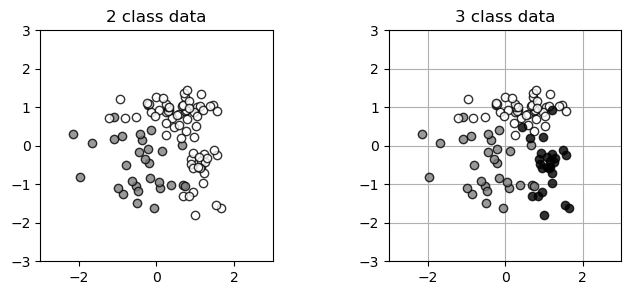

In [49]:
plt.figure(figsize=(7.5, 3))
plt.subplots_adjust(wspace=0.5)
# 2クラスデータ表示
plt.subplot(1, 2, 1)
plt.title('2 class data')
show_data2d(X, T2)
# 3クラスデータ表示
plt.subplot(1, 2, 2)
plt.title('3 class data')
show_data2d(X, T3)
plt.xlim(X0_min, X0_max)
plt.ylim(X1_min, X1_max)

plt.grid()
plt.show()

## 6.2.2 ロジスティック回帰
シグモイド関数に通す直線の式のｘを2つにすれば、二次元入力にも対応できる

早速モデルをロジスティック回帰モデルを定義

$ a = w_0 x_0 + w_1 x_1 + w_2 $

$ y = \frac{1}{1+e^{-(w_0 x_0 + w_1 x_1 + w_2)}} $

In [50]:
def logistic2(x0, x1, w):
    a = w[0] * x0 + w[1] * x1 + w[2]
    y = 1 / (1 + np.exp(-a))
    return y

二次元ロジスティック回帰モデルのサーフェス表示

In [51]:
def show3d_logistic2(ax, w):
    x0_n, x1_n = 50, 50
    x0 = np.linspace(X0_min, X0_max, x0_n)
    x1 = np.linspace(X1_min, X1_max, x1_n)
    xx0, xx1 = np.meshgrid(x0, x1)
    y = logistic2(xx0, xx1, w)
    ax.plot_surface(
        xx0, xx1, y,
        rstride=5, cstride=5, alpha=0.3, color='blue', edgecolor='gray'
        )
def show_data2d_3d(ax, x, t):
    col = ['gray', 'white']
    for i in range(2):
        ax.plot(
            x[t[:, i] == 1, 0],
            x[t[:, i] == 1, 1],
            1 - i,
            col[i],
            marker='o', linestyle='None', markeredgecolor='black', markersize=5, alpha=0.8
            )
    ax.view_init(elev=25, azim=-30)
    ax.set_xlabel('$x_0')
    ax.set_ylabel('$x_1')

グラフ表示

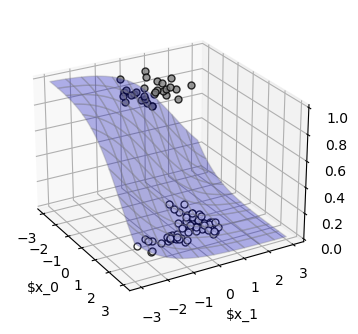

In [52]:
plt.figure(figsize=(5, 4))
ax = plt.subplot(projection='3d')
w = np.array([-1, -1, -1])
show3d_logistic2(ax, w)
show_data2d_3d(ax, X, T2)
plt.show()

モデルの等高線表示を作る \
w = [-1, -1, -1]の際の、ロジスティック回帰の出力を見ることができる。

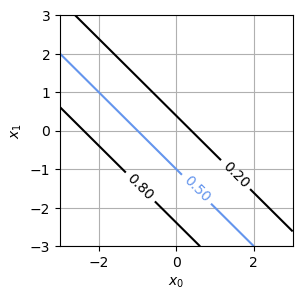

In [53]:
def show_contour_logistic2(w):
    x0_n, x1_n = 30, 30
    x0 = np.linspace(X0_min, X0_max, x0_n)
    x1 = np.linspace(X1_min, X1_max, x1_n)
    xx0, xx1 = np.meshgrid(x0, x1)
    y = logistic2(xx0, xx1, w)
    cont = plt.contour(
        xx0, xx1, y,
        levels=[0.2, 0.5, 0.8],
        colors = ['black', 'cornflowerblue', 'black']
    )
    cont.clabel(fmt='%.2f', fontsize=10)
    plt.xlabel('$x_0$')
    plt.ylabel('$x_1$')
    plt.grid()

# 表示
plt.figure(figsize=(3, 3))
w = np.array([-1, -1, -1])
show_contour_logistic2(w)
plt.show()

予測に使う関数として、ロジスティック回帰モデルを定義できたので、\
その予測値と実測値との誤差を図る誤差関数、交差エントロピー誤差を計算する関数を定義する

$ E(W) = - \frac{1}{N}logP(T|X) = - \frac{1}{N} \sum_{n=0}^{N-1} \{t_n log y_n + (1 - t_n) log(1-y_{n)\}} $

判断材料がXのときにTとなる確率P \
それを起こった事象をすべてかけあわせできた関数の最大値を求めれば、最適な確率を求めることができる。\
この式を下で使う

In [54]:
# 交差エントロピー誤差
def cee_logistic2(w, x, t):     # xはx0とx1を結合したもの
    N = x.shape[0]
    y = logistic2(x[:, 0], x[:, 1], w)
    # 平均の交差エントロピー誤差を求める
    cee = 0
    for n in range(len(y)):
        # 上式を表したもの
        cee = cee - (t[n, 0] * np.log(y[n]) + (1 - t[n, 0]) * np.log(1 - y[n]))
    cee = cee / N
    return cee

上のE(W)の式を偏微分すると、

$ \frac{dE}{dW_0} = \frac{1}{N} \sum_{n=0}^{N-1} (y_n-t_n)x_{n0} $

$ \frac{dE}{dW_1} = \frac{1}{N} \sum_{n=0}^{N-1} (y_n - t_n) x_{n1} $

$ \frac{dE}{dW_2} = \frac{1}{N} \sum_{n=0}^{N-1} (y_n - t_n) $

上の式のように、交差エントロピー誤差の偏微分を計算する関数を定義する。

In [57]:
def dcee_logistic2(w, x, t):        # xはx0とx1の2次元
    N = x.shape[0]
    y = logistic2(x[:, 0], x[:, 1], w)
    # 上の式の計算式
    dcee = np.zeros(3)
    for n in range(len(y)):
        dcee[0] = dcee[0] + (y[n] - t[n, 0]) * x[n, 0]
        dcee[1] = dcee[1] + (y[n] - t[n, 0]) * x[n, 1]
        dcee[2] = dcee[2] + (y[n] - t[n, 0])
    dcee = dcee / N
    return dcee

# テスト
w = np.array([-1, -1, -1])
dcee = dcee_logistic2(w, X, T2)
print('dCEE =', np.round(dcee, 6))

dCEE = [ 0.10272   0.04451  -0.063072]


平均交差エントロピー誤差が最小になるようにロジスティック回帰モデルのパラメータを更新する

w0 = -3.70, w1 = -2.54, w2 = -0.28
CEE = 0.22


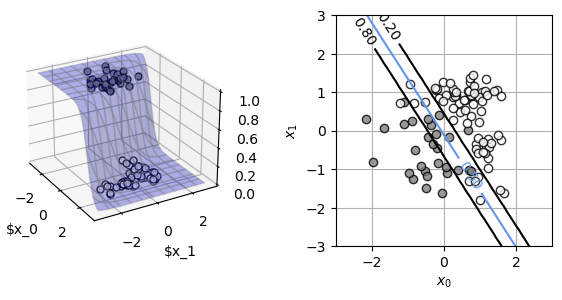

In [59]:
from scipy.optimize import minimize

# 二次元ロジスティック回帰モデルのパラメータ最適化
def fit_logistic2(w_init, x, t):
    # 最適化
    res = minimize(cee_logistic2, w_init, args=(x, t), jac=dcee_logistic2, method='CG')
    return res.x

# パラメータの最適化処理
w_init = np.array([-1, 0.0, 0.0])   # 初期値
w = fit_logistic2(w_init, X, T2)    # パラメータの最適化
cee = cee_logistic2(w, X, T2)       # 学習後の交差エントロピー誤差

# 結果の確認
print(f'w0 = {w[0]:.2f}, w1 = {w[1]:.2f}, w2 = {w[2]:.2f}')
print(f'CEE = {cee:.2f}')

# グラフ表示
plt.figure(figsize=(7, 3))
# サーフェス表示
plt.subplots_adjust(wspace=0.5)
ax = plt.subplot(1, 2, 1, projection='3d')
show3d_logistic2(ax, w)
show_data2d_3d(ax, X, T2)
# 等高線表示
plt.subplot(1, 2, 2)
show_data2d(X, T2)
show_contour_logistic2(w)
plt.show()

担当 6.1.7 \
範囲 6.1.6-6.2.2 \

# 6.3  2次元入力３クラス分類

## 6.3.1 3クラス分類ロジスティック回帰モデル
ソフトマックス関数を使うことで3クラス以上に分類することができる

*注意*： 入力総和$a_k$は、予測するクラスによって別の重みを使う

8/1 6.3.1-6.3.2

範囲　6.3.3 - 7.1.2 OpenCV C-1 - C-2 \
担当　7.0 - 7.1.1とOpenCV C-1

8/8 c-3 - c-5